## FastAI - Model Two

This is the second model we're going to train, also using the FastAI framework - and in fact, also a ResNet model, but this time we'll use ResNet50. This is a version of the model with more layers, and thus we should see an increased accuracy in its predictions. 

**_NOTE! This notebook and model training was all run on SaturnCloud with GPU Augmentation, and took several hours to run. I would not recommend running this without the use of a GPU. The README.md describes how to setup on SaturnCloud to run the notebooks there._**

#### Imports & Basic Setup

In [1]:
import torch
import torchvision
import fastai
from fastai.vision.all import *

In [2]:
path = "./data"
train_path = "./data/Training Data"
val_path = "./data/Validation Data"
test_path = "./data/Testing Data"

We start training with augmented data this time, unlike the previous one where we started out with plain data. 

In [3]:
item_tfms = [Resize(224)]
batch_tfms = [DihedralItem(p=0.01), RandomResizedCrop(size=224, min_scale=0.06),
              Warp(magnitude=0.3), Brightness(max_lighting=0.5), Contrast(max_lighting=0.3), Saturation(max_lighting=0.3),
              Hue(max_hue=0.2), RandomErasing(p=0.3, sh=0.2, max_count=3, min_aspect=0.2)]

db = DataBlock(blocks=(ImageBlock, CategoryBlock),
               get_items=get_image_files,
               item_tfms=item_tfms,
               batch_tfms=batch_tfms, 
               get_y=parent_label)

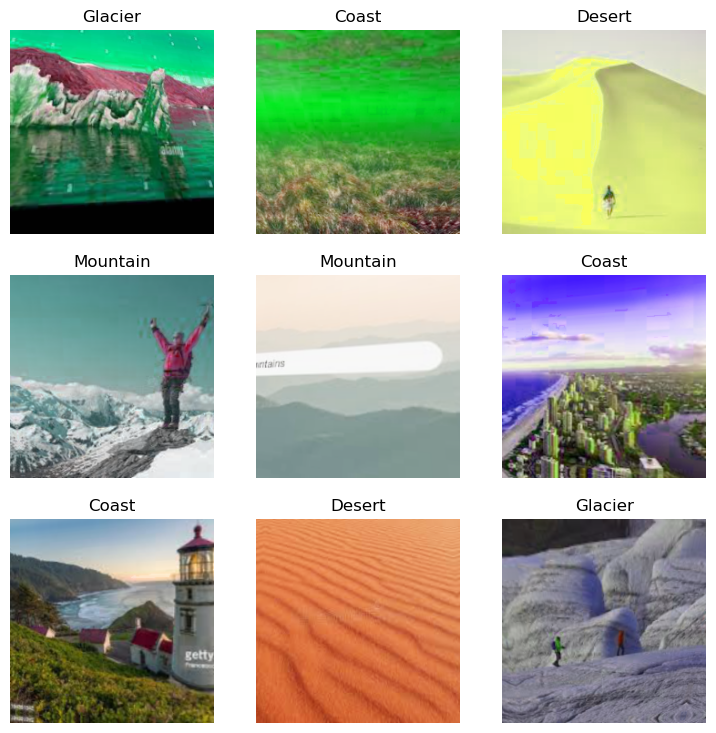

In [4]:
dataloader = db.dataloaders(path)
dataloader.show_batch()

The model I am using this time is similar to ResNet34 but it has more layers and so should have a greater accuracy. 

In [5]:
learner = vision_learner(dataloader, resnet50, metrics=accuracy, path=".")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
# Setting up checkpointing functions

early_stop = EarlyStoppingCallback(patience=10)
save_best_model = SaveModelCallback(fname='best_model_resnet50')

In [9]:
learner.fit_one_cycle(35, cbs=[early_stop, save_best_model])

epoch,train_loss,valid_loss,accuracy,time
0,0.997899,0.522137,0.826250,02:11
1,0.955830,0.491189,0.846250,02:16
2,0.818892,0.427367,0.857083,02:18
3,0.728048,0.412182,0.867500,02:18
4,0.614960,0.389811,0.870000,02:18
5,0.539600,0.355591,0.881667,02:18
6,0.508817,0.343686,0.877083,02:18
7,0.471766,0.345478,0.885000,02:18
8,0.428331,0.342191,0.881667,02:18
9,0.387222,0.325145,0.892500,02:18


Better model found at epoch 0 with valid_loss value: 0.5221366882324219.
Better model found at epoch 1 with valid_loss value: 0.4911891222000122.
Better model found at epoch 2 with valid_loss value: 0.42736685276031494.
Better model found at epoch 3 with valid_loss value: 0.41218194365501404.
Better model found at epoch 4 with valid_loss value: 0.3898105025291443.
Better model found at epoch 5 with valid_loss value: 0.35559114813804626.
Better model found at epoch 6 with valid_loss value: 0.3436864912509918.
Better model found at epoch 8 with valid_loss value: 0.3421909213066101.
Better model found at epoch 9 with valid_loss value: 0.3251454830169678.
Better model found at epoch 10 with valid_loss value: 0.32334500551223755.
Better model found at epoch 11 with valid_loss value: 0.3090652525424957.
Better model found at epoch 15 with valid_loss value: 0.3077266812324524.
Better model found at epoch 16 with valid_loss value: 0.30128300189971924.
No improvement since epoch 16: early stopp

In [10]:
learner.load('best_model_resnet50')

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Now we try to find a suitable learning rate, just like last time. 

In [11]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    model.lr_find()
    
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    lrs = model.recorder.lrs
    
    return lrs[min_loss_index] / 10

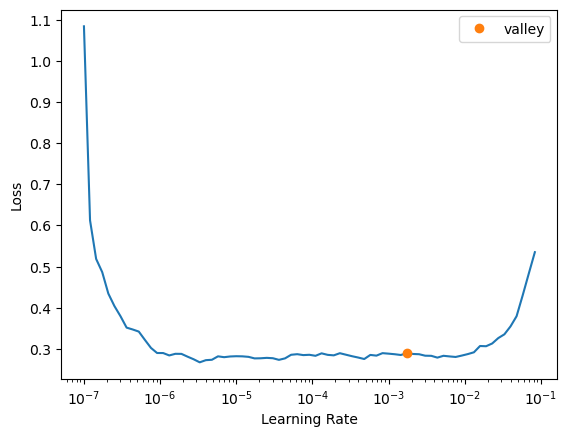

In [12]:
learning_rate = find_appropriate_lr(learner)


In [13]:
learner.fit_one_cycle(40, lr_max=slice(learning_rate/10, learning_rate), cbs=[early_stop, save_best_model])

epoch,train_loss,valid_loss,accuracy,time
0,0.269955,0.298788,0.910417,02:06
1,0.264682,0.302543,0.909583,02:11
2,0.261571,0.300801,0.908750,02:14
3,0.272923,0.300006,0.909167,02:16
4,0.278052,0.300993,0.910000,02:17
5,0.302496,0.305011,0.909583,02:17
6,0.288487,0.300474,0.910833,02:16
7,0.290750,0.302169,0.909167,02:16
8,0.280015,0.299391,0.910833,02:17
9,0.271391,0.299564,0.909167,02:18


Better model found at epoch 0 with valid_loss value: 0.2987881004810333.
No improvement since epoch 0: early stopping


Unfreezing the layers allows the training to modify more layers, and should increase the accuracy. After this I run it through a couple of cycles of training and adjusting learning rate. 

In [14]:
learner.unfreeze()

In [15]:
learner.fit_one_cycle(40, lr_max=slice(learning_rate/10, learning_rate), cbs=[early_stop, save_best_model])

epoch,train_loss,valid_loss,accuracy,time
0,0.270675,0.297932,0.910417,02:42
1,0.252840,0.299290,0.910000,02:50
2,0.284032,0.300737,0.911667,02:53
3,0.264034,0.300473,0.910833,02:54
4,0.274931,0.298511,0.910833,02:54
5,0.261815,0.297049,0.909583,02:54
6,0.251739,0.301427,0.909583,02:55
7,0.283501,0.297872,0.909583,02:56
8,0.272305,0.294898,0.909167,02:56
9,0.260791,0.297177,0.910000,02:56


Better model found at epoch 0 with valid_loss value: 0.2979317903518677.
Better model found at epoch 5 with valid_loss value: 0.29704853892326355.
Better model found at epoch 8 with valid_loss value: 0.2948981523513794.
Better model found at epoch 12 with valid_loss value: 0.294853538274765.
Better model found at epoch 16 with valid_loss value: 0.29392433166503906.
Better model found at epoch 18 with valid_loss value: 0.2919822335243225.
No improvement since epoch 18: early stopping


In [16]:
learner.load('best_model_resnet50')

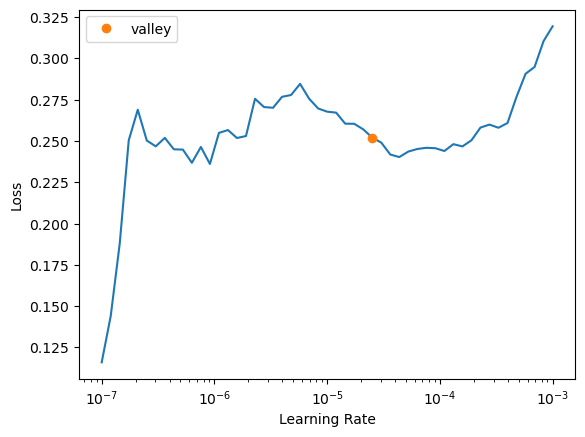

In [17]:
learning_rate = find_appropriate_lr(learner)


In [18]:
learner.fit_one_cycle(30, lr_max=slice(learning_rate/10, learning_rate), cbs=[early_stop, save_best_model])

epoch,train_loss,valid_loss,accuracy,time
0,0.282723,0.296081,0.909167,02:41
1,0.252761,0.293032,0.909167,02:50
2,0.281159,0.296007,0.910000,02:54
3,0.251013,0.296167,0.906667,02:56
4,0.247686,0.293488,0.908333,02:56
5,0.248712,0.293653,0.907917,02:56
6,0.264457,0.292601,0.907917,02:56
7,0.264953,0.296506,0.908750,02:56
8,0.265697,0.293611,0.911250,02:56
9,0.252114,0.292778,0.908333,02:56


Better model found at epoch 0 with valid_loss value: 0.2960813641548157.
Better model found at epoch 1 with valid_loss value: 0.2930315434932709.
Better model found at epoch 6 with valid_loss value: 0.29260122776031494.
Better model found at epoch 12 with valid_loss value: 0.29225653409957886.
Better model found at epoch 13 with valid_loss value: 0.2921121120452881.
Better model found at epoch 18 with valid_loss value: 0.29202890396118164.
Better model found at epoch 19 with valid_loss value: 0.29114285111427307.
No improvement since epoch 19: early stopping


In [19]:
learner.load('best_model_resnet50')

As we did in the '02_model1_train.ipynb' notebook, I chose to export the model in the ONNX format for ease of deploying and getting predictions. 

In [20]:
labels = learner.dls.vocab
labels

['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

In [21]:
pytorch_model = learner.model.eval()

softmax_layer = torch.nn.Softmax(dim=1)
normalisation_layer = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

final_model = nn.Sequential(
    normalisation_layer,
    pytorch_model,
    softmax_layer
)

In [37]:
dummy = torch.randn([1, 3, 224, 224], device=next(final_model.parameters()).device)

torch.onnx.export(
    final_model,
    dummy,
    "models/landscape_model_resnet50.onnx",
    do_constant_folding=True,
    export_params=True,
    input_names=['input'],
    output_names=['output'])

So far we have not tested either of these models against the testing data - meaning all we're going on is validation data. To keep the notebook size manageable and to keep things organised, this part is done seperately in the '04_model_test.ipynb' notebook.